NRES Signal to  trend analysis
---

Plot normalized signal to noise as repoprted by NRES pipeline.

Input: a number of input files containing the signal to noise for starts:

   Format:
   STAR_NAME  Vmag  SN   Texp
       
Code will calculate the S/N normalized to a 60 sec exposure. However, this calculation assumes that 
exposurs remain shot noise dominated in this process, i.e., this calculation is somewhat off. 



In [4]:
%matplotlib inline  
import numpy as np
import matplotlib.pyplot as plt
import dateutil.parser
import nres_snanalysis

In [5]:
plt.rcParams["figure.figsize"] = (10,6)
from matplotlib import style
plt.style.use('ggplot')

In [3]:
# Search through the data of a nigs / sites
for site,instrument in [('elp','nres02'),
                        ('lsc','nres01')]:

    for date in (['20171127',]):
        print site,instrument, date
        nres_snanalysis.crawldata (site, instrument, date)

elp nres02 20171127
Searching for HR7596_FLUX -> HR7596
elpnrs02-fl17-20171127-0016-e91 HR7596_FLUX 5.63100004196 164.3 600
Searching for HR7596_FLUX -> HR7596
elpnrs02-fl17-20171127-0017-e91 HR7596_FLUX 5.63100004196 161.4 600
Searching for 51 PEG -> 51 PEG
elpnrs02-fl17-20171127-0019-e91 51_PEG 5.46000003815 207.2 600
lsc nres01 20171127
Searching for HE 0139-2826 -> HE 0139-2826
lscnrs01-fl09-20171127-0025-e91 HE_0139-2826 13.7399997711 23.1 3600
Searching for HD49933_TEMPL -> HD49933
lscnrs01-fl09-20171127-0026-e91 HD49933_TEMPL 5.78299999237 73.7 600
Searching for HD49933_TEMPL -> HD49933
lscnrs01-fl09-20171127-0027-e91 HD49933_TEMPL 5.78299999237 77.2 600
Searching for HR1544_FLUX -> HR1544
lscnrs01-fl09-20171127-0029-e91 HR1544_FLUX 4.34999990463 150.3 400
Searching for HD 38529 -> HD 38529
lscnrs01-fl09-20171127-0030-e91 HD_38529 5.92399978638 111.6 900
Searching for HD96670 -> HD96670
lscnrs01-fl09-20171127-0033-e91 HD96670 7.42999982834 33.3 900
Searching for HD96670 -> HD966

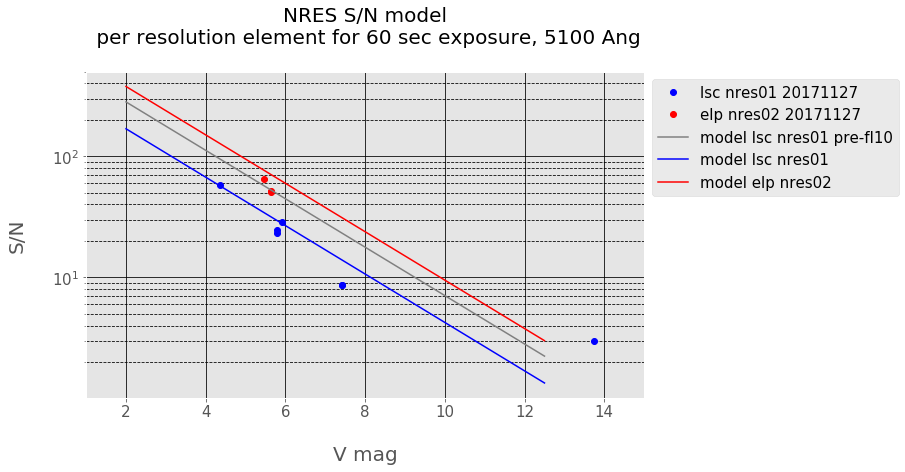

In [6]:
# Do the fancy plotting
ron=5

fig, ax = plt.subplots(1)

for site,instrument in [
    ('lsc','nres01'),
    ('elp','nres02'),
    ]:

    for date in (['20171127',]):
        pass
        plotfile ('%s-%s.txt' % (instrument, date), color='red' if site == 'elp' else 'blue', 
              label='%s %s %s' %(site,instrument,date),
              refflux=0)


plotfile (None , color='gray',  label ='lsc nres01 pre-fl10', refflux=500000, ron=0)
plotfile (None , color='blue',   label ='lsc nres01', refflux=180000, ron=0)
plotfile (None , color='red', label ='elp nres02', refflux=900000, ron=0)


lgd = plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1,  fontsize=15)
plt.xlim([1,15])
plt.xlabel ( "\nV mag",  fontsize=20)
plt.ylabel ("S/N\n",  fontsize=20)
plt.title ("NRES S/N model\n per resolution element for 60 sec exposure, 5100 Ang\n",  fontsize=20)

ax.grid(b=True, which='major', color='k', linestyle='-')
ax.grid(b=True, which='minor', color='k', linestyle='--')
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=10)
plt.subplots_adjust(top=0.88)
plt.savefig("nres01-02-model20171127.png", box_extra_artists=(lgd,), bbox_inches="tight");  